# **Preprocessing Pipeline**

In [1]:
# Imports
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import fftconvolve

import matplotlib.pyplot as plt

## **1. Synchronization of recorded audio files**

In [3]:
# Load and synchronize audio files
audio_normal, sr1 = librosa.load("../Data/raw/10_experiment8_5tesMic_Schaufel_rundumlaufen/Normal_10_experiment8.wav", sr=None)
print("audio_normal loaded.")

# Load and synchronize anomalous audio files
audio_anomaly, sr2 = librosa.load("../Data/raw/A_09-10_experiment7-8.wav", sr=None)
print("audio_anomaly loaded.")

audio_normal loaded.
audio_anomaly loaded.


## **2. Transformations (STFT & MEL)**

In [5]:
# Apply STFT (Short-term Fourier Transform) for all files
print("Applying Short-term Fourier Transform (STFT)...")
stft_normal = librosa.stft(audio_normal, n_fft=1024, hop_length=512)
stft_anomaly = librosa.stft(audio_anomaly, n_fft=1024, hop_length=512)


Applying Short-term Fourier Transform (STFT)...


In [6]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_normal = librosa.feature.melspectrogram(S=np.abs(stft_normal), sr=sr1, n_mels=128)
mel_anomaly = librosa.feature.melspectrogram(S=np.abs(stft_anomaly), sr=sr2, n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_normal = librosa.power_to_db(mel_normal, ref=np.max)
mel_db_anomaly = librosa.power_to_db(mel_anomaly, ref=np.max)

# Normalize the mel-spectrograms (optional)
print("Normalizing Mel-spectrograms...")
mel_db_normal = (mel_db_normal - np.mean(mel_db_normal)) / np.std(mel_db_normal)
mel_db_anomaly = (mel_db_anomaly - np.mean(mel_db_anomaly)) / np.std(mel_db_anomaly)

# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("../Data/mel/mel_db_pi1.npy", mel_db_normal)
np.save("../Data/mel/mel_db_Api1.npy", mel_db_anomaly)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...
Saving Mel-spectrograms...


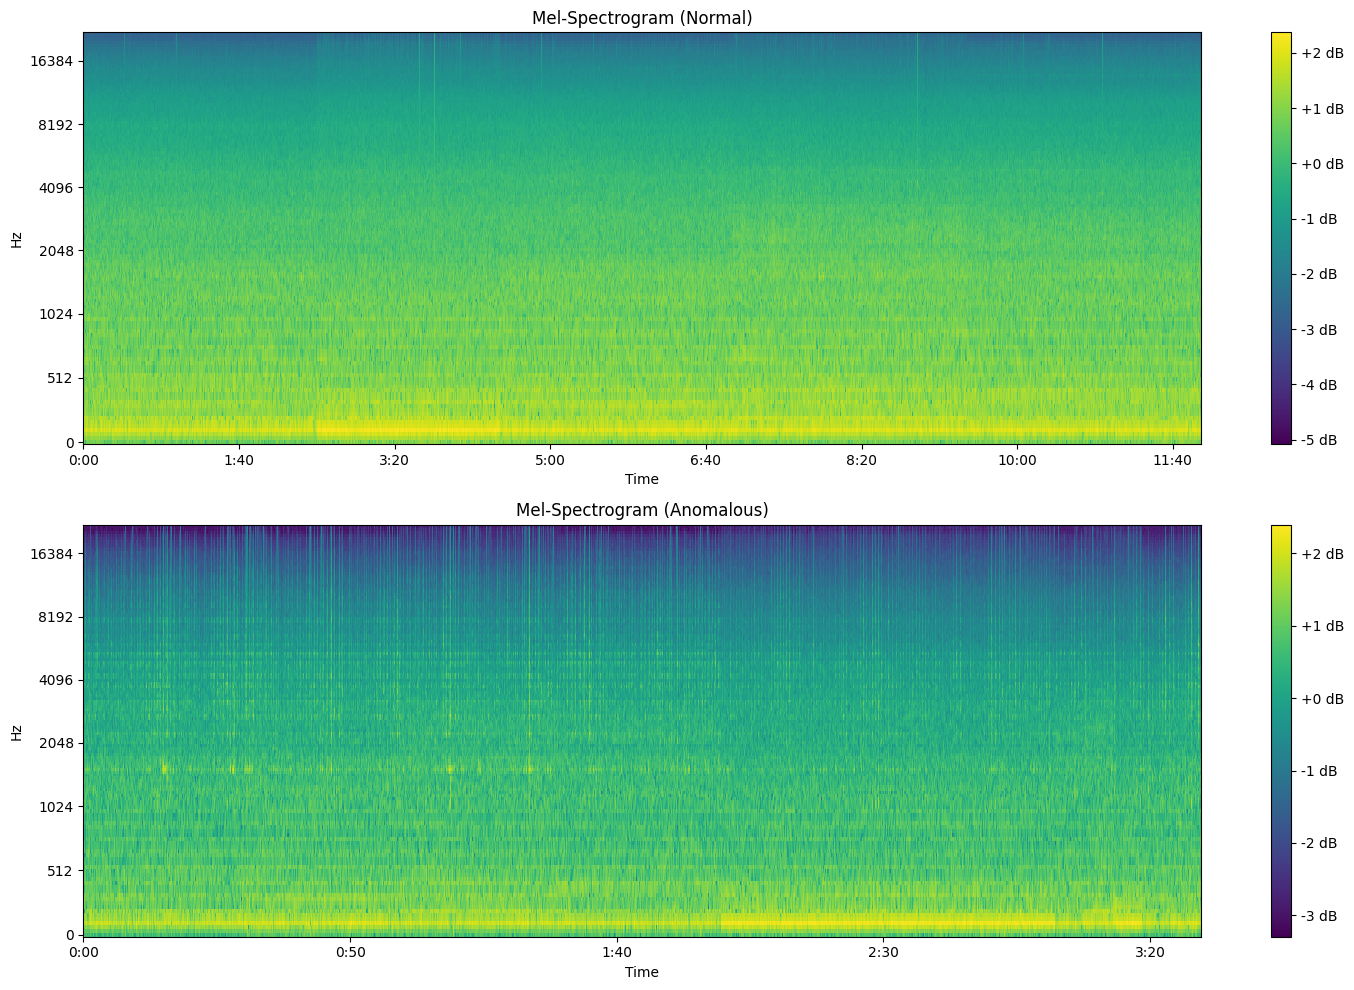

In [9]:
# Create a figure for the subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_normal, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0])
axs[0].set(title='Mel-Spectrogram (Normal)')
fig.colorbar(img1, ax=axs[0], format='%+2.0f dB')

# Plot Anomalous Pi1
img3 = librosa.display.specshow(mel_db_anomaly, sr=sr2, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1])
axs[1].set(title='Mel-Spectrogram (Anomalous)')
fig.colorbar(img3, ax=axs[1], format='%+2.0f dB')


# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrograms_comparison.png')
plt.show()

## **3. Frame Generation**

In [10]:
def generate_frames(mel_spectrogram, frame_size=128, hop_size=64):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))

    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]

    return frames

# Generate frames for normal Pi1 and Pi2
frames_normal = generate_frames(mel_db_normal)

# Generate frames for anomalous Pi1 and Pi2
frames_anomaly = generate_frames(mel_db_anomaly)

print(f"Frames Pi1 (Normal): {frames_normal.shape}")
print(f"Frames Api1 (Anomalous): {frames_anomaly.shape}")

Frames Pi1 (Normal): (965, 128, 128)
Frames Api1 (Anomalous): (280, 128, 128)


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, roc_curve
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import librosa

# Helper function to convert complex numbers to real
def convert_complex_to_real(value):
    return complex(value).real

# Feature extraction function (assuming a simplified version for demonstration)
def get_features(filename, n_fft=2048, sr=22050, means=False):
    ''' Extracts MFCC, Log Mel energy, and Chroma (CENS) features '''
    y, sr = librosa.load(filename, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    log_mel = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft), ref=np.max)
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    
    features = np.hstack([mfcc, log_mel, chroma])
    if means:
        features = np.mean(features, axis=1)
    
    return features

# Function to apply feature extraction on a DataFrame
def get_df_feat(df, n_fft=2048, sr=22050, means=False):
    feat_cols = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        filename = row['filename']
        feat = get_features(filename, n_fft=n_fft, sr=sr, means=means)
        feat_cols.append(feat)
    feat_df = pd.DataFrame(feat_cols)
    feat_df = feat_df.applymap(convert_complex_to_real)
    return feat_df

# **Autoencoder**

## 4.1 Architecture

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape[0] * input_shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_shape[0] * input_shape[1]),
            nn.Sigmoid(),  # Sigmoid to ensure values are in the range [0,1]
            nn.Unflatten(1, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
input_shape = (frames_normal.shape[1], frames_normal.shape[2])  # Shape based on frames
autoencoder = Autoencoder(input_shape)

# Print model architecture
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=16, bias=True)
    (6): ReLU()
    (7): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16384, bias=True)
    (7): Sigmoid()
    (8): Unflatten(dim=1, unflattened_size=(128, 128))
  )
)


## 4.2 Data preparation

In [ ]:
from sklearn.model_selection import train_test_split

# Split the normal data into training and testing sets
frames_normal_train, frames_normal_test = train_test_split(
    frames_normal, test_size=0.2, random_state=42
)

# Reshape training normal frames
X_train = frames_normal_train.reshape(len(frames_normal_train), -1)

# Reshape testing normal and anomalous frames
X_test_normal = frames_normal_test.reshape(len(frames_normal_test), -1)
X_test_anomaly = frames_anomaly.reshape(len(frames_anomaly), -1)

# Combine normal and anomalous data for testing
X_test = np.vstack([X_test_normal, X_test_anomaly])

# Assign label 1 to normal test frames and -1 to anomalous frames
y_test = np.array([1] * len(X_test_normal) + [-1] * len(X_test_anomaly))

: 

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Split frames for Pi1
frames_pi1_train, frames_pi1_val = train_test_split(frames_normal, test_size=0.2, random_state=42)
frames_pi2_train, frames_pi2_val = train_test_split(frames_pi2, test_size=0.2, random_state=42)

# Combine training sets from both Pi1 and Pi2
frames_train = np.concatenate((frames_pi1_train, frames_pi2_train), axis=0)
frames_val = np.concatenate((frames_pi1_val, frames_pi2_val), axis=0)

# Convert to PyTorch tensors
frames_train_tensor = torch.Tensor(frames_train)
frames_val_tensor = torch.Tensor(frames_val)

# Create DataLoaders for training and validation
train_dataset = TensorDataset(frames_train_tensor, frames_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(frames_val_tensor, frames_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 4.3 AE Training


In [15]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training the autoencoder
epochs = 50
for epoch in range(epochs):
    autoencoder.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = autoencoder(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

    print(f'Epoch {epoch+1}/{epochs}, '
          f'Training Loss: {running_loss/len(train_loader):.4f}, '
          f'Validation Loss: {val_loss/len(val_loader):.4f}')

# Save the trained model
torch.save(autoencoder.state_dict(), "autoencoder_model.pth")

Epoch 1/50, Training Loss: 1.1920, Validation Loss: 1.0285
Epoch 2/50, Training Loss: 0.8658, Validation Loss: 0.7270
Epoch 3/50, Training Loss: 0.7038, Validation Loss: 0.6870
Epoch 4/50, Training Loss: 0.6874, Validation Loss: 0.6811
Epoch 5/50, Training Loss: 0.6830, Validation Loss: 0.6784
Epoch 6/50, Training Loss: 0.6811, Validation Loss: 0.6771
Epoch 7/50, Training Loss: 0.6800, Validation Loss: 0.6758
Epoch 8/50, Training Loss: 0.6789, Validation Loss: 0.6747
Epoch 9/50, Training Loss: 0.6777, Validation Loss: 0.6741
Epoch 10/50, Training Loss: 0.6768, Validation Loss: 0.6727
Epoch 11/50, Training Loss: 0.6760, Validation Loss: 0.6724
Epoch 12/50, Training Loss: 0.6757, Validation Loss: 0.6717
Epoch 13/50, Training Loss: 0.6750, Validation Loss: 0.6713
Epoch 14/50, Training Loss: 0.6747, Validation Loss: 0.6705
Epoch 15/50, Training Loss: 0.6737, Validation Loss: 0.6696
Epoch 16/50, Training Loss: 0.6720, Validation Loss: 0.6669
Epoch 17/50, Training Loss: 0.6685, Validation Lo

## 4.4 AE Evaluation

In [16]:
# Evaluate on validation data to set a threshold for anomaly detection
autoencoder.eval()
with torch.no_grad():
    reconstructed_frames = autoencoder(frames_val_tensor)
    reconstruction_error = torch.mean(torch.abs(frames_val_tensor - reconstructed_frames), dim=(1, 2))

# Convert error to NumPy array for further processing
reconstruction_error = reconstruction_error.numpy()

# Define a threshold for anomaly detection (e.g., 95th percentile)
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly detection threshold: {threshold}")

Anomaly detection threshold: 0.5996569395065308


## 4.5 Test AE

NameError: name 'test_reconstructed_error_Api1' is not defined

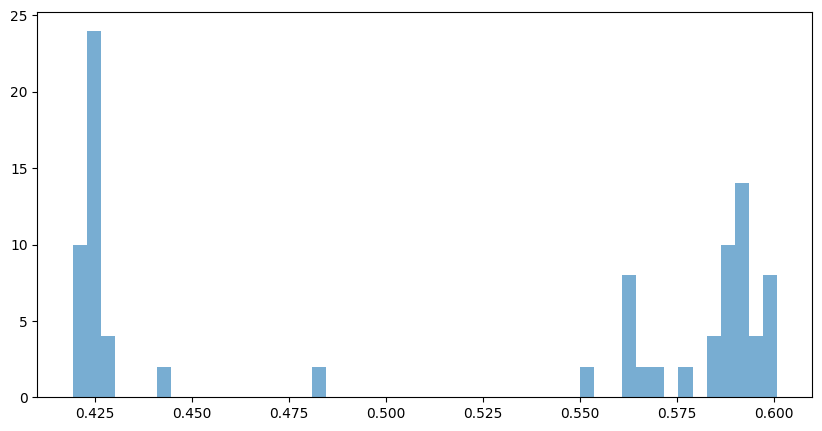

In [17]:
import matplotlib.pyplot as plt

# Plot reconstruction error distribution for normal validation set
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50, alpha=0.6, label='Normal Validation')
plt.hist(test_reconstructed_error_Api1, bins=50, alpha=0.6, label='Anomalous Api1')
plt.hist(test_reconstructed_error_Api2, bins=50, alpha=0.6, label='Anomalous Api2')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Visualize original and reconstructed frames for one anomalous frame
def plot_original_vs_reconstructed(original, reconstructed, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{title} - Original")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{title} - Reconstructed")
    plt.colorbar()
    plt.show()

# Example: Compare one anomalous frame from Api1
with torch.no_grad():
    frame_index = 0  # Adjust this index to view different frames
    original_frame = frames_Api1_tensor[frame_index].numpy()
    reconstructed_frame = test_reconstructed_Api1[frame_index].numpy()
    plot_original_vs_reconstructed(original_frame, reconstructed_frame, "Api1 Anomalous Frame")

## 4.5 Test AE

In [ ]:
# Test on new data (Anomalous Pi1 and Pi2)
frames_Api1_tensor = torch.Tensor(frames_anomaly)
frames_Api2_tensor = torch.Tensor(frames_Api2)

with torch.no_grad():
    test_reconstructed_Api1 = autoencoder(frames_Api1_tensor)
    test_reconstructed_error_Api1 = torch.mean(torch.abs(frames_Api1_tensor - test_reconstructed_Api1), dim=[1, 2])

    test_reconstructed_Api2 = autoencoder(frames_Api2_tensor)
    test_reconstructed_error_Api2 = torch.mean(torch.abs(frames_Api2_tensor - test_reconstructed_Api2), dim=[1, 2])

# Convert to NumPy
test_reconstructed_error_Api1 = test_reconstructed_error_Api1.numpy()
test_reconstructed_error_Api2 = test_reconstructed_error_Api2.numpy()

# Detect anomalies
anomalies_Api1 = test_reconstructed_error_Api1 > threshold
anomalies_Api2 = test_reconstructed_error_Api2 > threshold

print(f"Number of anomalies detected in Api1: {np.sum(anomalies_Api1)}")
print(f"Number of anomalies detected in Api2: {np.sum(anomalies_Api2)}")

Number of anomalies detected in Api1: 130
Number of anomalies detected in Api2: 155


## 4.6 Save Model and Results

In [19]:
# Save the trained model
torch.save(autoencoder.state_dict(), 'trained_autoencoder.pth')

# Save reconstruction errors
np.save('reconstruction_errors_Api1.npy', test_reconstructed_error_Api1)
np.save('reconstruction_errors_Api2.npy', test_reconstructed_error_Api2)

## Next Steps:
- Treshold tuning + test data
- Real-time deplyoment: integrate model into real-time system to analyze live data